# D213 Performance Assessment NLM2 Task 1 by Renzo Espinoza

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy import signal
import pmdarima as pm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import math

In [3]:
sns.set_theme(style='darkgrid')
plt.rcParams['figure.dpi'] = 150

In [4]:
df = pd.read_csv('teleco_time_series.csv')

# Part III:  Data Preparation

<AxesSubplot: title={'center': 'Revenue in Millions for Last Two Years'}, xlabel='Day', ylabel='Revenue'>

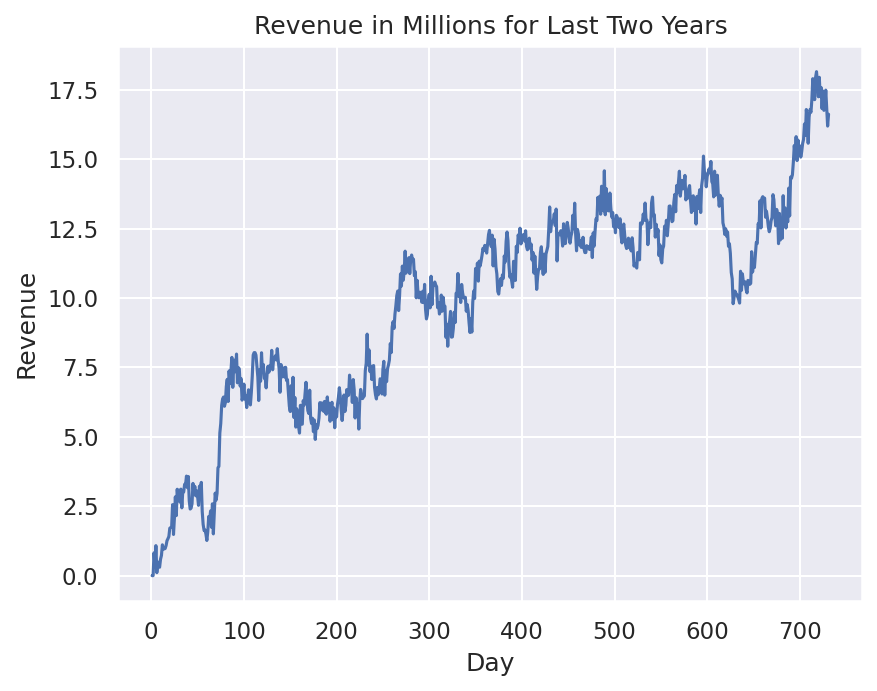

In [5]:
plt.title('Revenue in Millions for Last Two Years')
sns.lineplot(data=df, x='Day', y='Revenue')

In [6]:
df

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
...,...,...
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813


In [7]:
# Check for duplicates
df[df.duplicated()]

,Day,Revenue


In [8]:
# Check for nulls
df.isnull().any()

Day        False
Revenue    False
dtype: bool

In [9]:
adf_result = adfuller(df.Revenue)

In [10]:
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.9246121573101842
p-value: 0.3205728150793961


### The ADF statistic is not a large negative number and with a p-value much greater than 0.05, we cannot reject the null hypothesis stating that the time series is not stationary.

In [11]:
diff_one = np.diff(df.Revenue, n=1)

In [12]:
adf_diff_one = adfuller(diff_one)

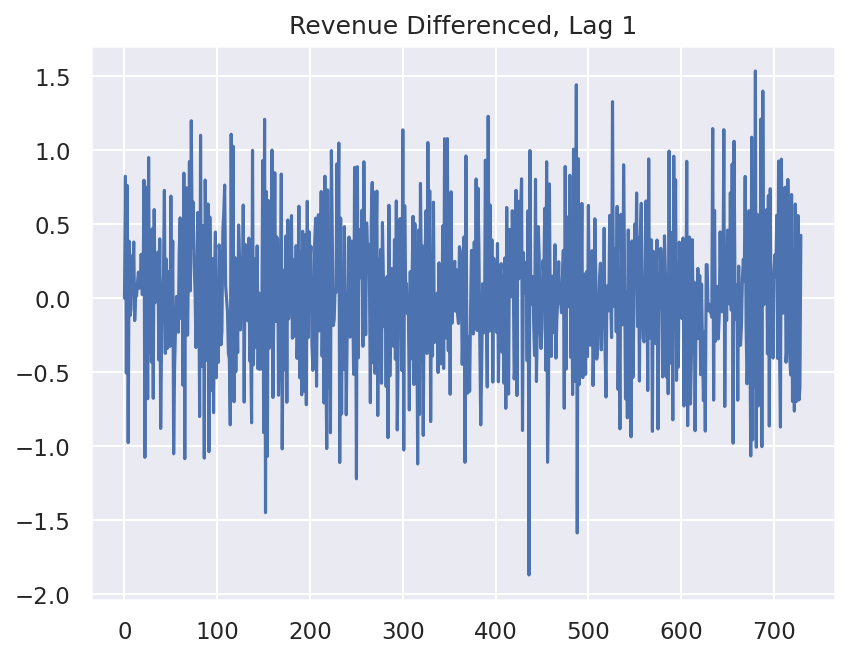

In [13]:
plt.title('Revenue Differenced, Lag 1')
plt.plot(diff_one)

In [14]:
print(f'ADF Statistic: {adf_diff_one[0]}')
print(f'p-value: {adf_diff_one[1]}')

ADF Statistic: -44.874527193876
p-value: 0.0


### It took one round of differencing for the data to become stationary, so the order of integration is 1, or d = 1

In [15]:
df['Date'] = (pd.date_range(start=datetime(2019, 1, 1),
            periods=df.shape[0], freq='24H'))
df.set_index('Date',inplace=True)
df

,Day,Revenue
Date,,
2019-01-01,1,0.000000
2019-01-02,2,0.000793
2019-01-03,3,0.825542
2019-01-04,4,0.320332
2019-01-05,5,1.082554
...,...,...
2020-12-27,727,16.931559
2020-12-28,728,17.490666
2020-12-29,729,16.803638


In [16]:
# 75/25 Train/Test split
train = df.Revenue[:548]
test = df.Revenue[548:]

In [17]:
df['Date'] = (pd.date_range(start=datetime(2019, 1, 1),
            periods=df.shape[0], freq='24H'))
df.set_index('Date',inplace=True)
df

,Day,Revenue
Date,,
2019-01-01,1,0.000000
2019-01-02,2,0.000793
2019-01-03,3,0.825542
2019-01-04,4,0.320332
2019-01-05,5,1.082554
...,...,...
2020-12-27,727,16.931559
2020-12-28,728,17.490666
2020-12-29,729,16.803638


In [18]:
cleaned_df = pd.DataFrame(diff_one, columns=['Revenue_diff_one'])

In [19]:
cleaned_df['Date'] = (pd.date_range(start=datetime(2019, 1, 2),
            periods=cleaned_df.shape[0], freq='24H'))
cleaned_df.set_index('Date',inplace=True)
cleaned_df

,Revenue_diff_one
Date,
2019-01-02,0.000793
2019-01-03,0.824749
2019-01-04,-0.505210
2019-01-05,0.762222
2019-01-06,-0.974900
...,...
2020-12-27,0.170280
2020-12-28,0.559108
2020-12-29,-0.687028


In [20]:
cleaned_df.to_csv('PA1_cleaned_data.csv')

# Part IV:  Model Identification and Analysis

In [21]:
decomp = seasonal_decompose(cleaned_df)

<AxesSubplot: title={'center': 'Seasonality'}, xlabel='Date'>

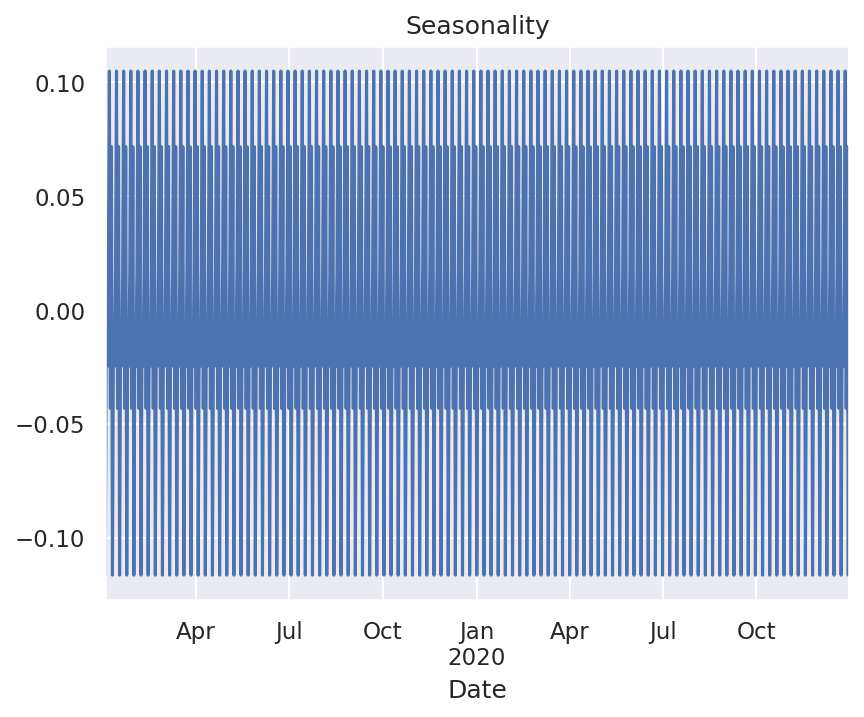

In [22]:
plt.title('Seasonality')
decomp.seasonal.plot()

<AxesSubplot: title={'center': 'Seasonality (First Two Months)'}, xlabel='Date'>

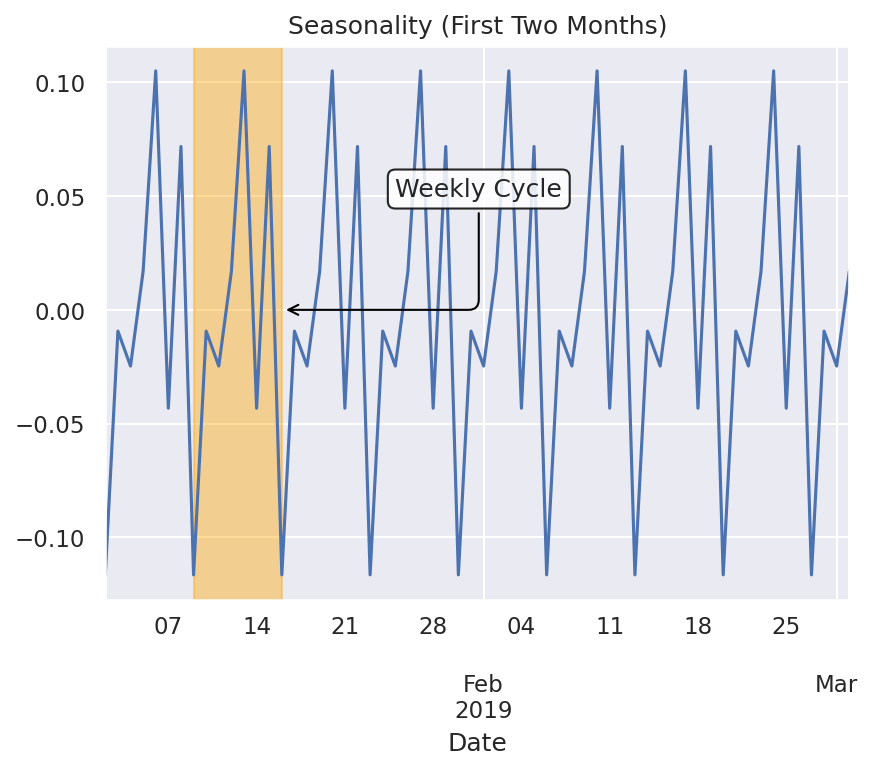

In [23]:
fig, ax = plt.subplots()
plt.title('Seasonality (First Two Months)')
plt.axvspan(*mdates.datestr2num(['1/9/2019', '1/16/2019']), color='orange', alpha=0.4)
bbox = dict(boxstyle ='round', fc ='white', ec='black', alpha=0.85)
arrowprops = dict(
    arrowstyle = '->',
    connectionstyle = 'angle, angleA = 90,\
    rad = 10',
    color='black')
ax.annotate('Weekly Cycle', xy=('1/16/2019', 0), xytext=('1/25/2019', 0.05), arrowprops=arrowprops, bbox=bbox)
decomp.seasonal[:60].plot()

### Seasonality still appears in the time series after differencing. The time series follows a weekly seasonal cycle, so the period for seasonal differencing, *m*, will be set to 7

<AxesSubplot: title={'center': 'Trend'}, xlabel='Date'>

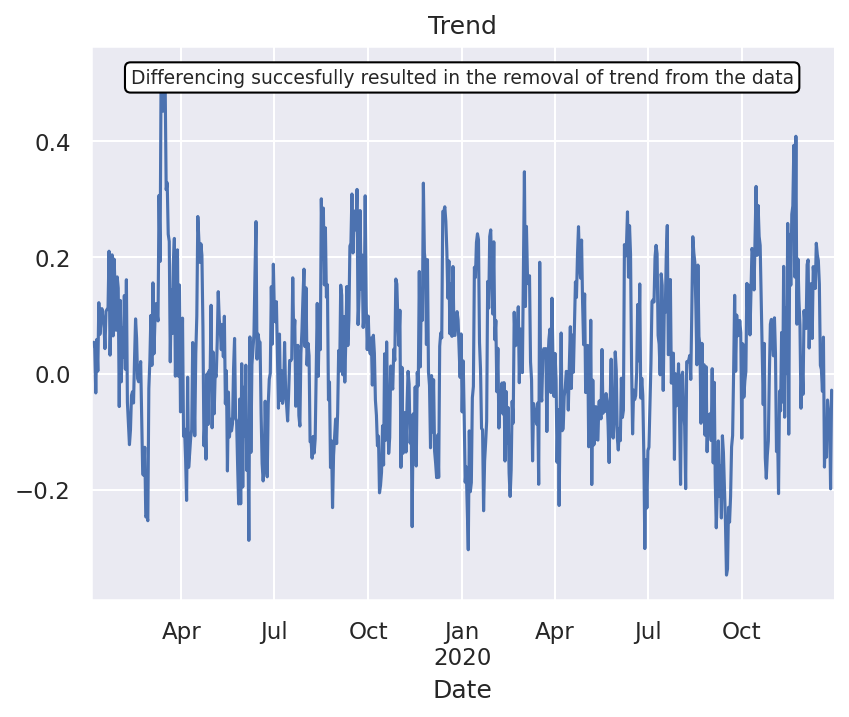

In [47]:
fig, ax = plt.subplots()
plt.title('Trend')
plt.text('1/1/20', 0.5, 'Differencing succesfully resulted in the removal of trend from the data', 
         horizontalalignment='center', 
         bbox = dict(fc='white', ec='black', boxstyle='round'),
        size=9)
decomp.trend.plot()

### Differencing succesfully resulted in the removal of trend from the data

Text(15, -0.65, 'There are no significant autocorrelation coefficients after lag 2, therefore the data is stationary')

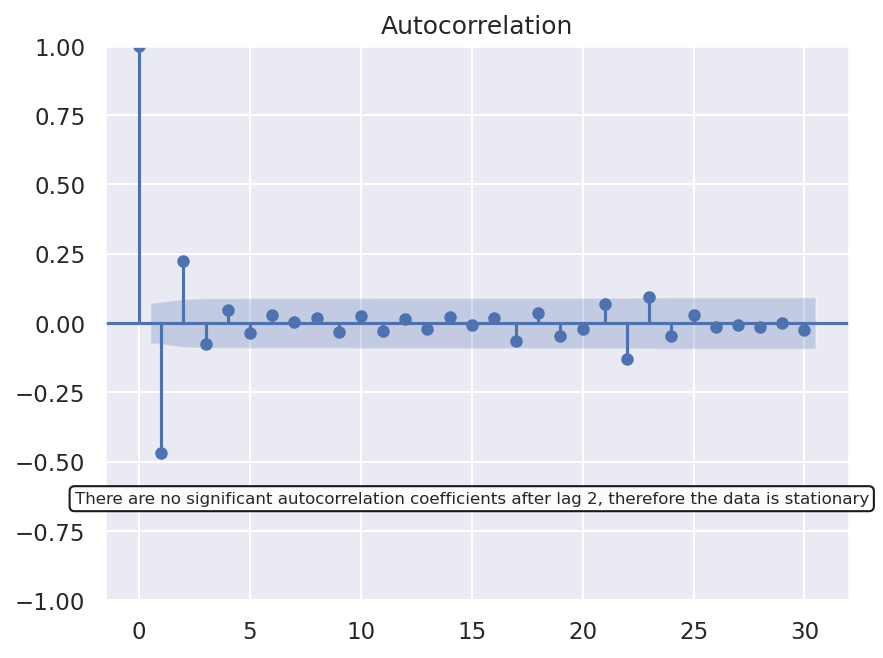

In [25]:
plot_acf(diff_one, lags=30)
plt.text(15, -0.65, 
         'There are no significant autocorrelation coefficients after lag 2, therefore the data is stationary', 
         horizontalalignment='center', 
         bbox = dict(fc='white', ec='black', boxstyle='round', alpha=0.9),
        size=8)

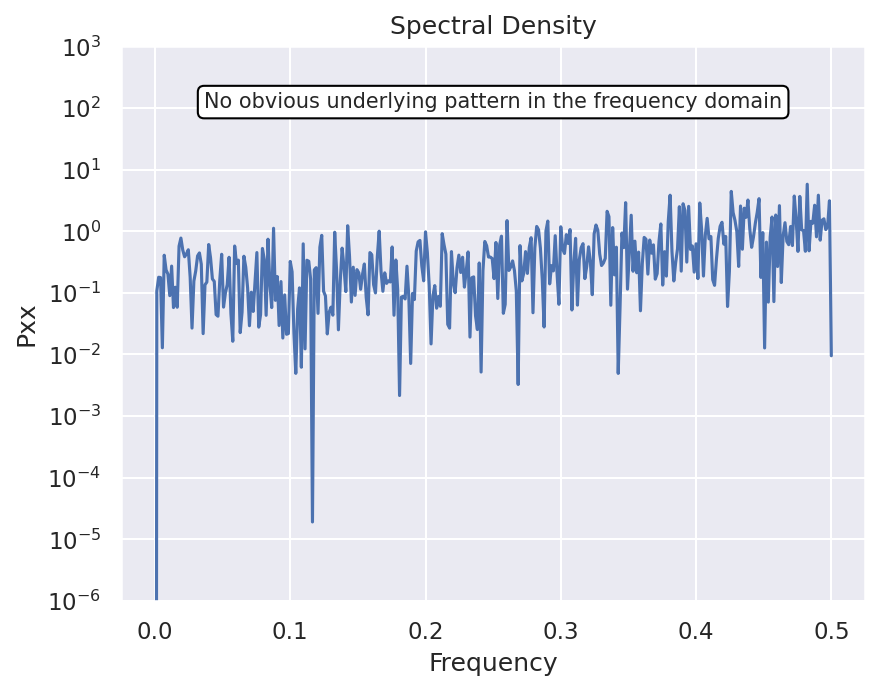

In [26]:
f, Pxx_den = signal.periodogram(cleaned_df.Revenue_diff_one)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e3])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Pxx')
plt.text(0.25, 100, 
         'No obvious underlying pattern in the frequency domain', 
         horizontalalignment='center', 
         bbox = dict(fc='white', ec='black', boxstyle='round',),
        size=10)
plt.show()

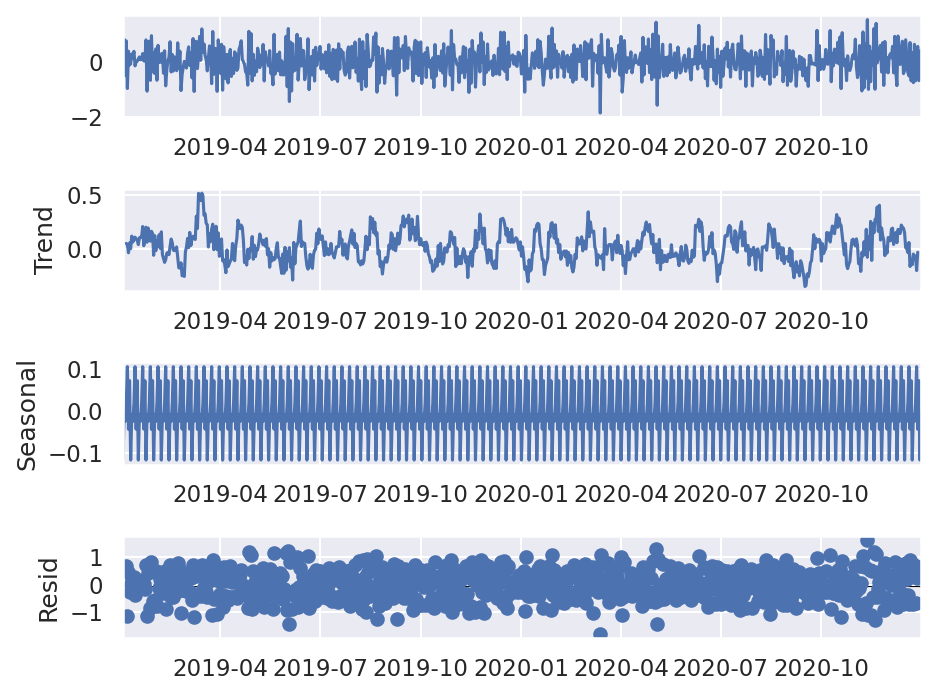

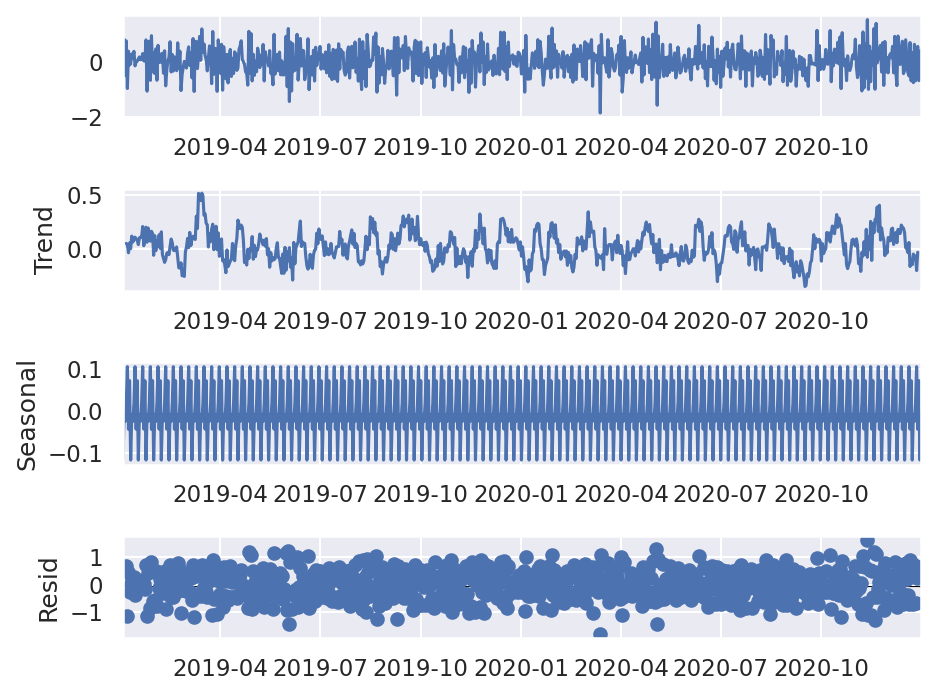

In [27]:
decomp.plot()

<AxesSubplot: title={'center': 'Residuals'}, xlabel='Date'>

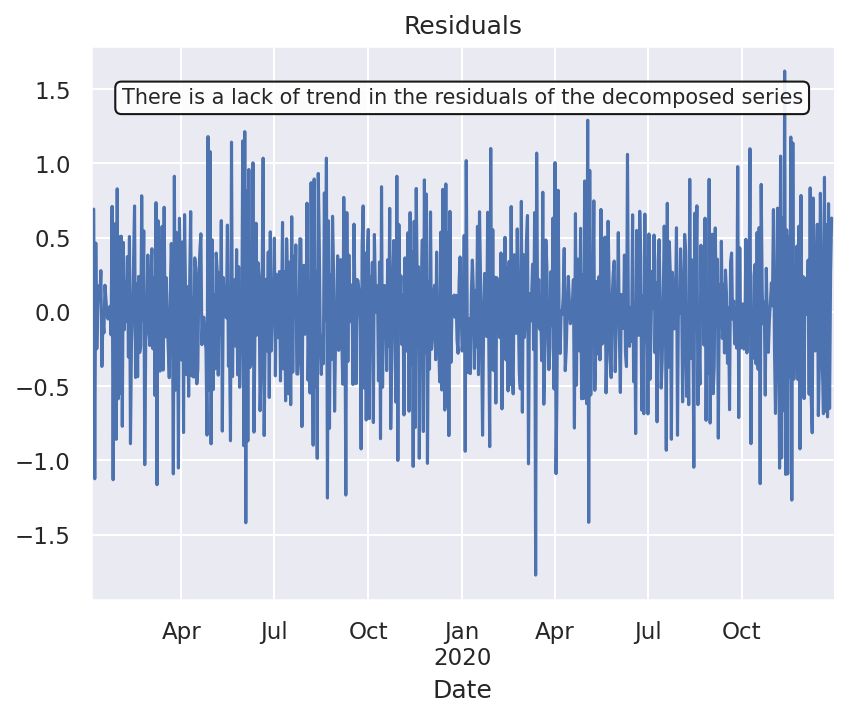

In [28]:
plt.title('Residuals')
plt.text('1/1/2020', 1.4, 
         'There is a lack of trend in the residuals of the decomposed series', 
         horizontalalignment='center', 
         bbox = dict(fc='white', ec='black', boxstyle='round', alpha=0.9),
        size=10)
decomp.resid.plot()

In [29]:
auto_model = pm.auto_arima(train, d=1, trace=True, seasonal=True, m=7, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=738.279, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=863.397, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=732.592, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=759.919, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=862.259, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=731.041, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=732.584, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=733.020, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=733.024, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=758.172, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=734.556, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=731.534, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[7] intercept
Total fit time: 1.273 seconds


In [30]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  548
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -362.521
Date:                Sat, 04 Mar 2023   AIC                            731.041
Time:                        19:35:27   BIC                            743.954
Sample:                             0   HQIC                           736.089
                                - 548                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0318      0.020      1.572      0.116      -0.008       0.071
ar.L1         -0.4676      0.037    -12.532      0.000      -0.541      -0.394
sigma2         0.2203      0.014     15.655      0.000       0.193       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.96   Prob(JB):                         0.53
Heteroskedasticity (H):               1.01   Skew:                            -0.07
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The residuals have a constant variance and are not correlated. This is a good sign.

In [31]:
pred, confint = auto_model.predict(n_periods=test.size, return_conf_int=True)

In [32]:
pred_series = pd.Series(pred,index=test.index)
confint = pd.DataFrame(confint)

In [33]:
print('Predictions:')
print(pred)

Predictions:
[11.99884061 11.81112411 11.9306618  11.9065325  11.94957951 11.96121599
 11.98753951 12.00699562 12.02966281 12.05082856 12.07269635 12.09423588
 12.1159289  12.13755016 12.15920496 12.18084408 12.20249054 12.22413356
 12.24577819 12.26742207 12.2890663  12.31071036 12.33235451 12.35399861
 12.37564274 12.39728685 12.41893097 12.44057509 12.4622192  12.48386332
 12.50550744 12.52715156 12.54879568 12.57043979 12.59208391 12.61372803
 12.63537215 12.65701626 12.67866038 12.7003045  12.72194862 12.74359273
 12.76523685 12.78688097 12.80852509 12.8301692  12.85181332 12.87345744
 12.89510156 12.91674567 12.93838979 12.96003391 12.98167803 13.00332214
 13.02496626 13.04661038 13.0682545  13.08989862 13.11154273 13.13318685
 13.15483097 13.17647509 13.1981192  13.21976332 13.24140744 13.26305156
 13.28469567 13.30633979 13.32798391 13.34962803 13.37127214 13.39291626
 13.41456038 13.4362045  13.45784861 13.47949273 13.50113685 13.52278097
 13.54442508 13.5660692  13.58771332 1

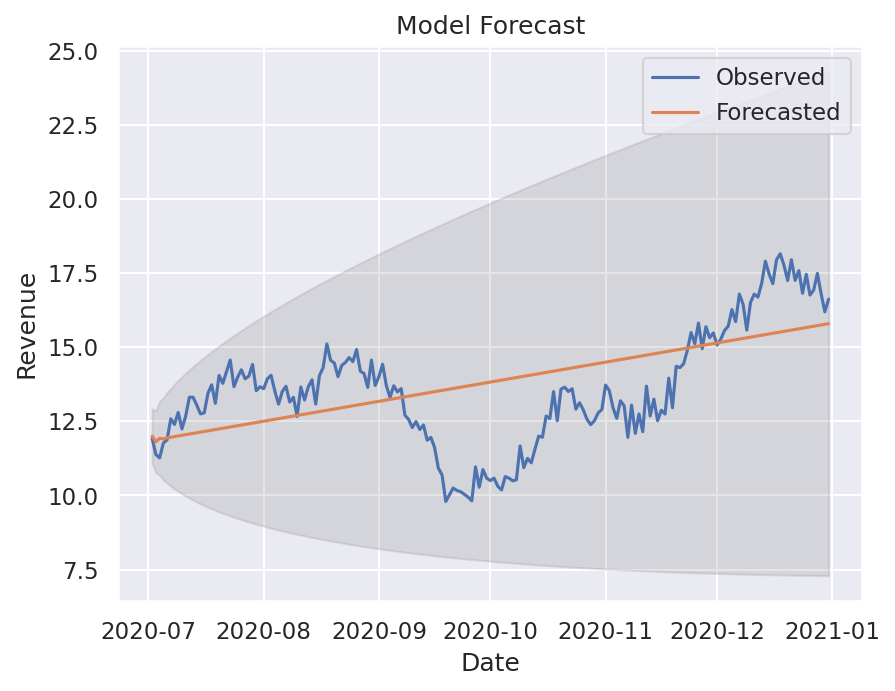

In [34]:
plt.plot(test, label='Observed')
plt.plot(pred_series, label='Forecasted')
plt.fill_between(pred_series.index,
                confint[0],
                confint[1],color='grey',alpha=.2)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Model Forecast')
plt.legend()

# Part V:  Data Summary and Implications

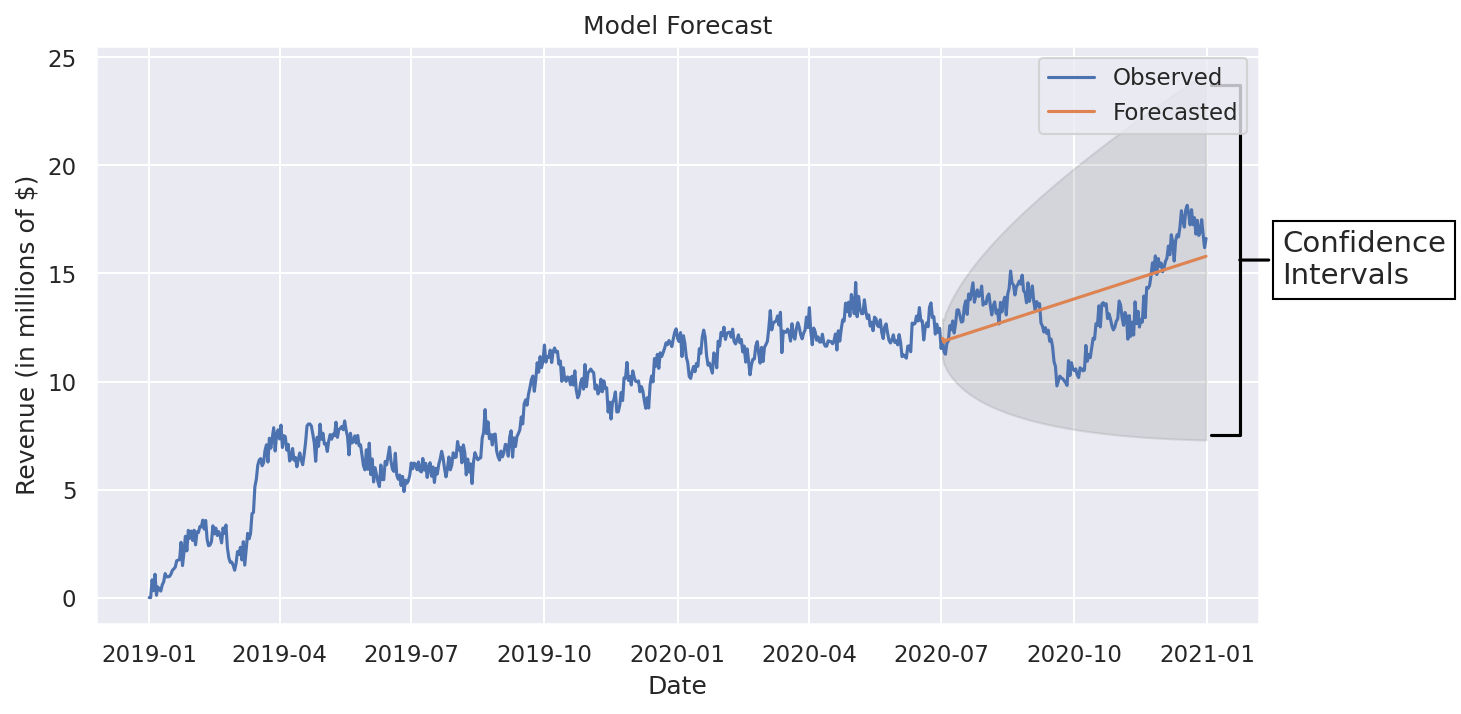

In [96]:
plt.figure(figsize=(10,5))
plt.plot(df.Revenue, label='Observed')
plt.plot(pred_series, label='Forecasted')
plt.fill_between(pred_series.index,
                confint[0],
                confint[1],color='grey',alpha=.2)
plt.xlabel('Date')
plt.ylabel('Revenue (in millions of $)')
plt.title('Model Forecast')
datetime_object = datetime.strptime('01/01/21', '%m/%d/%y')
plt.annotate('Confidence\nIntervals', xy=(0.98, 0.63), xytext=(1.02, 0.63), xycoords='axes fraction',
            fontsize=14,
            bbox=dict(boxstyle='square', fc='white', ec='black'), va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1', lw=1.5, color='black'))
plt.legend()

In [102]:
MSE = mean_squared_error(test, pred)
RMSE = math.sqrt(MSE)

print(f"The root mean squared error is {RMSE}")

The root mean squared error is 1.776281956146564


### The RMSE is a tad high considering the data ranges from 0-16 and the unit of measurement is millions of dollars

In [97]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [100]:
mape_arima = mape(test, pred)
print(f"The mean absolute percentage error is {mape_arima}")

The mean absolute percentage error is 11.828595451209807


### A MAPE of 11.83% is good according to this article:
https://stephenallwright.com/good-mape-score/

## Overall, the model does a good job of capturing the trend of the data and has a good MAPE and RMSE score. I would recommend using this model to project the revenue for the next two quarters.